# Chat with your PDF: Llama 2 for Question-Answering task.

Providers of large commercial language models like OpenAI's GPT-4 have made access to these technologies widely available through straightforward API integrations. However, due to concerns regarding data security and regulatory compliance, some organizations prefers to handle model operations internally or within a secure, private network. The advent of open-source language models has significantly diminished dependence on external commercial providers by offering a broad array of alternatives.

For organizations opting to deploy these models in-house, either on local servers or cloud environments, selecting the appropriate computational resources becomes crucial for them. Although utilizing GPU resources might seem advantageous for performance reasons, the associated costs can quickly become prohibitive.

In this workshop, we will look into the process of employing quantized versions of open-source large language models for CPU-based local inference, focusing on retrieval-augmented generation tasks, such as document-based Q&A. Specifically, we will explore how to implement the advanced Llama 2 chat model for these purposes in Python.

## What is Quantization?

Quantization is a useful technique for making large language models (LLMs) less demanding on computer resources. These models are powerful but need a lot of memory and processing power. By using quantization, we can make these models smaller and faster without losing much in the way of performance. In simple terms, quantization means using fewer bits to store numbers. For LLMs, this means making the model's details less precise by saving the weights in simpler formats. This is especially helpful for running models on devices with limited resources, like CPUs or small, embedded systems. A typical approach is to change the model's weights from 16-bit floating-point numbers to simpler 8-bit integers.

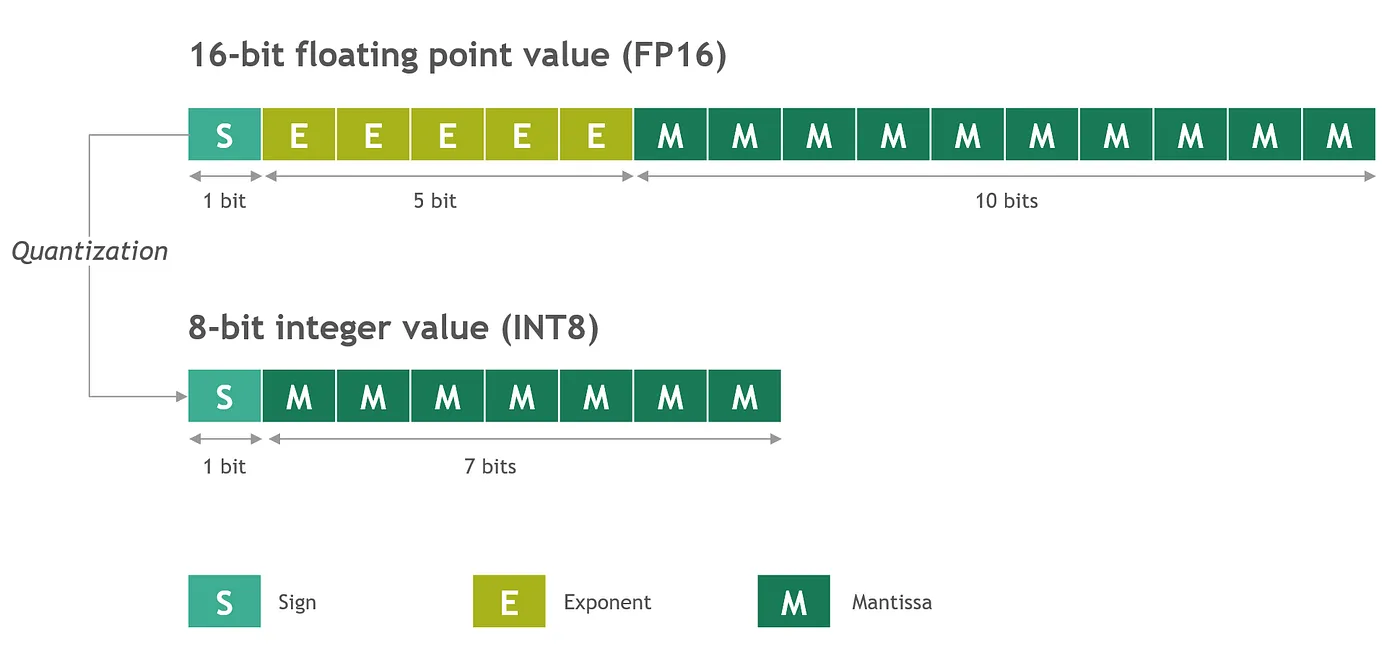

## Architecture of the document Q&A LLM application:

We will be utilizing Langchain for this application. LangChain is a framework designed for building applications that leverage language models. It offers a wide variety of integrations and connectors for data, enabling developers to link together different components to create complex applications such as chatbots, data analysis tools, and systems for answering questions based on documents.

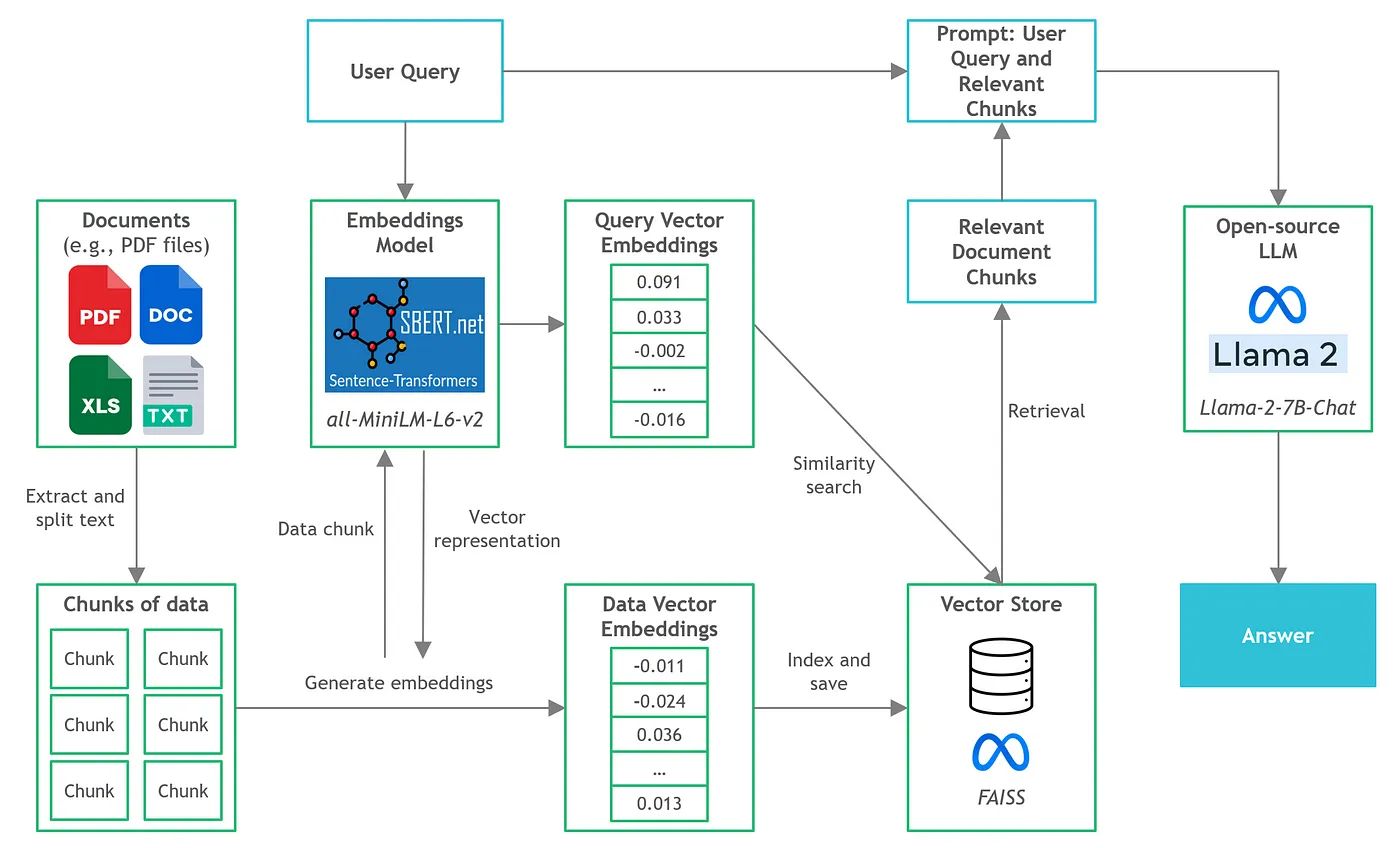

This diagram illustrates the steps involved in a question-answering system that utilizes machine learning models and document analysis:

1. **Documents**: These are the files that contain information, such as PDFs, Word Docs, Excel files, or text files. They form the knowledge base for the system to draw answers from.

2. **Extract and Split Text**: The system processes these documents to break down the content into smaller segments called "chunks," which makes the data easier to work with.

3. **Embeddings Model**: Utilizing the `Sentence-Transformers all-MiniLM-L6-v2` model, the system transforms the text chunks into numerical vectors known as embeddings, encapsulating the semantic information in a format that the machine can process.

4. **Query Vector Embeddings**: Similarly, the question you ask (the "User Query") is converted into an embedding, allowing the system to handle it computationally.

5. **Similarity Search**: The system then compares the question embedding with the document chunk embeddings to find the closest matches, effectively identifying which chunks are most likely to answer your question.

6. **Vector Store (FAISS)**: The embeddings are stored in a vector store, which is a specialized database optimized for searching through embeddings quickly. FAISS is the technology used here.

7. **Retrieve Relevant Document Chunks**: The system retrieves the document chunks that most closely match the query based on the similarity search.

8. **Prompt**: A "prompt" is formulated, combining your question with the retrieved document chunks, and it is fed into a language model.

9. **Open-source LLM (Llama 2)**: This refers to the Llama-2-7B-Chat language model, which is tasked with generating an appropriate answer based on the information provided in the prompt.

10. **Answer**: The outcome of the process is the answer generated by the Llama model, which is then presented to you.

In essence, this system reads and interprets your question, searches for the best information snippets from a set of documents, and constructs a response using a language model.

Other tools required are:

### C-Transformers and GGML library

C Transformers is a Python library that serves as a bridge to transformer models coded in C/C++ through the use of the GGML library. The GGML library, developed by ggml.ai, is a specialized tensor library for machine learning. It makes it possible to run large models efficiently on standard consumer hardware by supporting integer quantization and incorporating optimization techniques.
Consequently, models based on GGML, which are quantized and stored in a binary format, can be executed efficiently on CPU hardware. For this project, where Python is the primary programming language, C Transformers is employed to provide Python access to models built with GGML. C Transformers is compatible with a select group of open-source models, including well-known ones like Llama, GPT4All-J, MPT, and Falcon.

### Sentence-Transformers Embeddings Model

The sentence-transformers library is a Python tool that simplifies the process of generating embeddings, which are dense vectors representing sentences, text, or images. This library supports over 100 languages, enabling the comparison of embeddings to identify sentences with similar meanings. For our project, we will use the all-MiniLM-L6-v2 model from the open-source offerings of sentence-transformers due to its balance of speed and quality in producing general-purpose embeddings.

### FAISS (Facebook AI Similarity Search)

FAISS is a library created for the efficient searching and clustering of dense vector data. By indexing a collection of embeddings with FAISS, users can quickly find the closest vectors within that collection using its advanced semantic search capabilities. While FAISS isn't a traditional vector storage system like a database, it's optimized for fast nearest-neighbor finding tasks.

## Open-Source LLM Selection

In the dynamic landscape of open-source large language models (LLMs), the HuggingFace Open LLM leaderboard serves as a valuable resource for identifying high-performing models. The choice to utilize the Llama-2-7B-Chat model, specifically its GGML 8-bit version, is guided by a comprehensive evaluation of several key factors:

### Model Type: Llama 2
- **Open-Source and Compatibility**: This model is open-source and supported by the C Transformers library, making it an accessible and practical option for development.
- **Performance**: As of today, it is distinguished by its superior performance across a range of metrics on the Open LLM leaderboard, marking a significant enhancement over the original Llama model.
- **Community Engagement**: Its widespread mention and utilization within the developer community further attest to its effectiveness and popularity.

### Model Size: 7B
- **Suitability for Task**: The task at hand involves summarizing sections of documents, a process that doesn't require the capabilities of extremely large models (e.g., 65B). Hence, a 7B model size is adequately efficient and suitable for document Q&A applications.

### Fine-tuned Version: Llama-2-7B-Chat
- **Optimized for Q&A**: Unlike the base Llama-2-7B model which is designed for text completion, the Llama-2-7B-Chat variant is specifically fine-tuned for conversational interactions and Q&A, aligning perfectly with the project’s needs.
- **Commercial Use Licensing**: This model is partially licensed for commercial use, leveraging extensive public instruction datasets and over a million human annotations for improved performance.

### Quantized Format: 8-bit
- **Memory Efficiency**: Given the limitation of 16GB RAM, the 8-bit version of this model is ideal as it requires only about 9.6GB of memory, offering a practical solution to hardware constraints.
- **Quality and Performance**: This format ensures a response quality comparable to that of 16-bit models, effectively balancing efficiency with performance. It's a strategic choice over smaller quantized formats, which could compromise accuracy and response quality.

# Step 1 — Process data and build vector database:

In [1]:
!pip install ctransformers==0.2.5 \
             faiss-cpu==1.7.4 \
             "fastapi>=0.96.0" \
             "ipykernel>=6.23.1" \
             langchain==0.0.225 \
             pypdf==3.8.1 \
             python-box==7.0.1 \
             python-dotenv==1.0.0 \
             sentence-transformers==2.2.2 \
             "uvicorn>=0.22.0"

In [2]:
from langchain.vectorstores import FAISS  # Import the FAISS class from langchain.vectorstores for similarity search and clustering
from langchain.text_splitter import RecursiveCharacterTextSplitter  # Import RecursiveCharacterTextSplitter for splitting text into smaller chunks
from langchain.document_loaders import PyPDFLoader, DirectoryLoader  # Import PyPDFLoader and DirectoryLoader for loading documents from directories and PDF files
from langchain.embeddings import HuggingFaceEmbeddings  # Import HuggingFaceEmbeddings to use embeddings models from Hugging Face

# Initialize a DirectoryLoader to load PDF files from the 'data/' directory, searching for files matching the "*.pdf" pattern using the PyPDFLoader class
loader = DirectoryLoader('data/',
                         glob="*.pdf",
                         loader_cls=PyPDFLoader)
documents = loader.load()  # Load the documents using the loader defined above

# Create a text splitter that splits texts into chunks of 500 characters with a 50 character overlap between chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500,
                                               chunk_overlap=50)
texts = text_splitter.split_documents(documents)  # Split the loaded documents into chunks using the defined text splitter

# Load the sentence-transformers model 'all-MiniLM-L6-v2' for generating embeddings, setting the computation to run on CPU
embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2',
                                   model_kwargs={'device': 'cpu'})

# Create a FAISS vector store from the document chunks' embeddings, using the previously loaded embeddings model
vectorstore = FAISS.from_documents(texts, embeddings)
vectorstore.save_local('vectorstore/db_faiss')  # Persist the generated FAISS vector store to the local filesystem under 'vectorstore/db_faiss'


/Users/tanyakhanna/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


After running the above, the vector store will be generated and saved in the local directory named 'vectorstore/db_faiss', and is ready for semantic search and retrieval.

# Step 2 — Set up prompt template

In [3]:
qa_template = """Use the following pieces of information to answer the user's question.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Context: {context}
Question: {question}
Only return the helpful answer below and nothing else.
Helpful answer:
"""

# Step 3 — Download the Llama-2–7B-Chat GGML binary file

Since we will be running the LLM locally, we need to download the binary file of the quantized Llama-2–7B-Chat model.

We can do so by visiting TheBloke’s Llama-2–7B-Chat GGML (https://huggingface.co/TheBloke/Llama-2-7B-Chat-GGML) page hosted on Hugging Face and then downloading the GGML 8-bit quantized file named llama-2–7b-chat.ggmlv3.q8_0.bin.

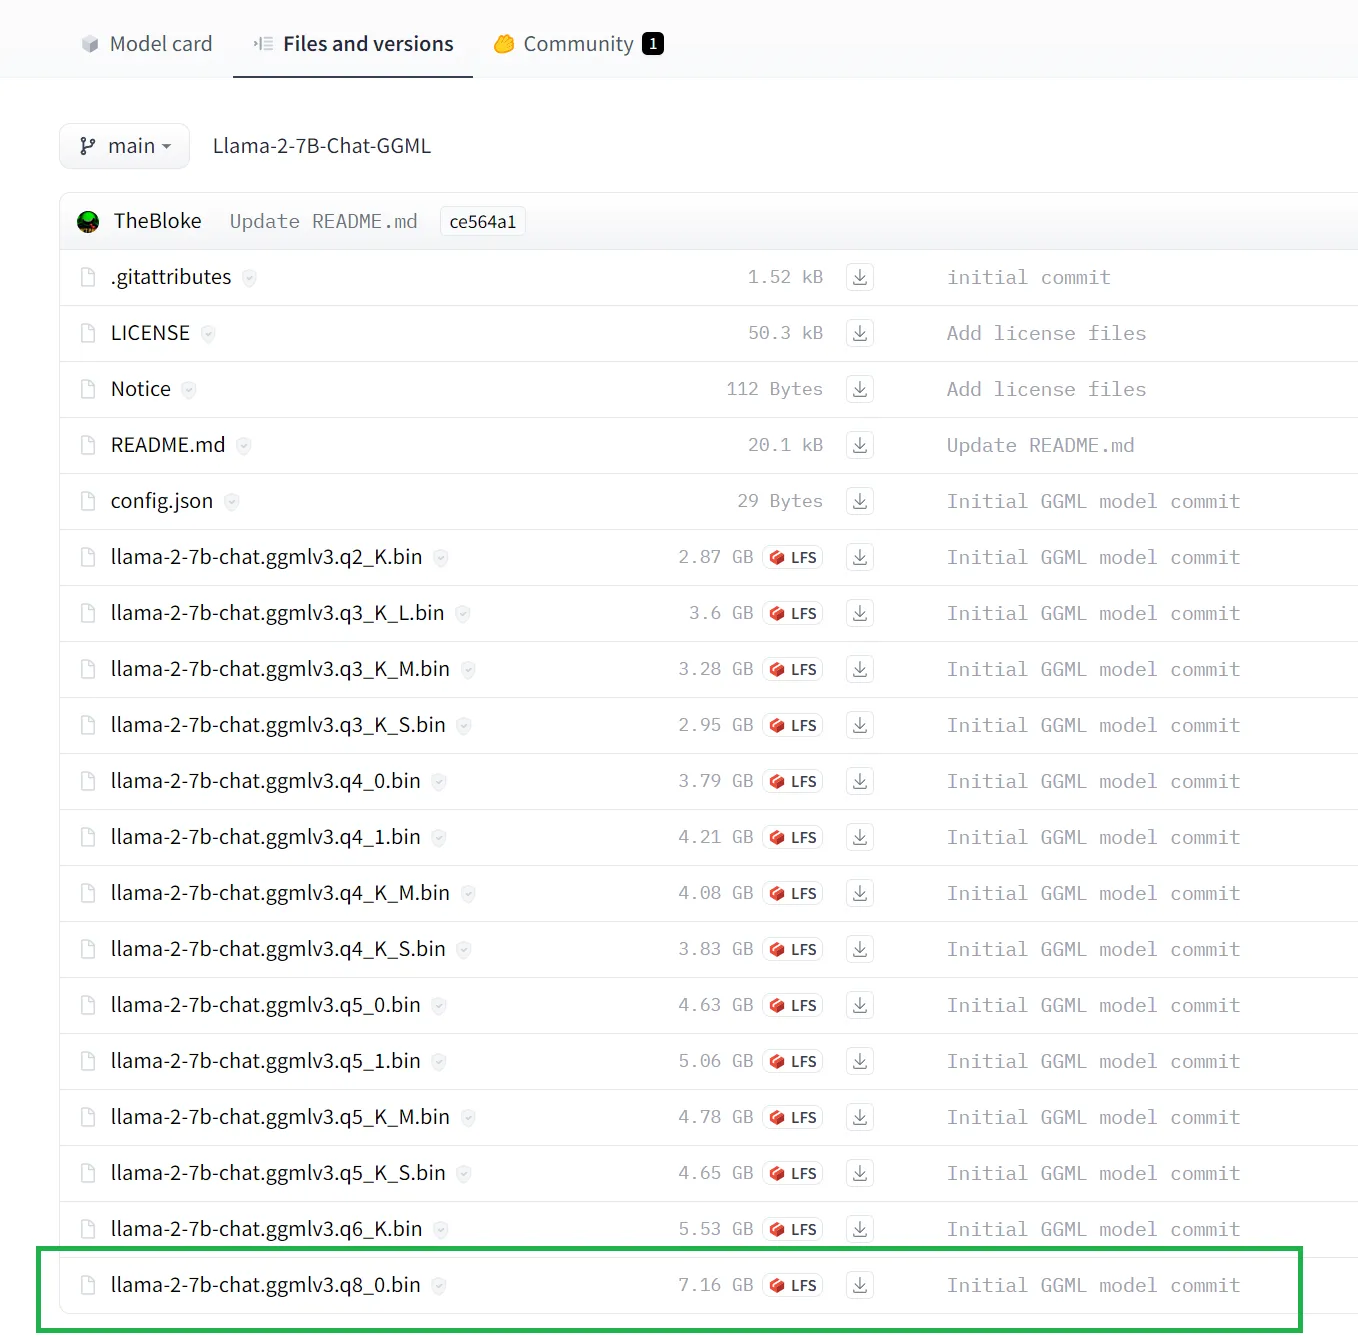

# Step 4 — Setup LLM

To utilize the GGML model we downloaded, we will leverage the integration between C Transformers and LangChain. Specifically, we will use the CTransformers LLM wrapper in LangChain, which provides a unified interface for the GGML models.

In [4]:
from langchain.llms import CTransformers  # Import the CTransformers class from langchain.llms for interfacing with LLM models

# Initialize a CTransformers object to interact with the Llama-2-7B-Chat model
llm = CTransformers(model='llama-2-7b-chat.ggmlv3.q8_0.bin',  # Specify the file path to the GGML quantized Llama model
                    model_type='llama',  # Indicate the type of model, in this case, a Llama model
                    config={'max_new_tokens': 256,  # Configuration setting for the maximum number of new tokens to generate
                            'temperature': 0.01})  # Configuration setting for the temperature, influencing randomness in generation


`max_new_tokens` and `temperature`, are particularly important for controlling the behavior of text generation:

- **`max_new_tokens`**: This setting determines the maximum number of new tokens (which can be words or parts of words in the case of subword tokenization) that the model will generate as a response to an input prompt. By setting a limit with `max_new_tokens`, you can manage the length and detail of the generated text. For instance, a limit of 256 tokens restricts the model to produce responses that are up to 256 tokens long, ensuring the output is direct and to the point.

- **`temperature`**: The `temperature` parameter affects the randomness of the model's predictions by adjusting the logits before applying the softmax function during the generation process. A lower `temperature` value (approaching 0) results in more confident and less varied predictions, making the model's output more deterministic. A higher `temperature`, on the other hand, increases randomness, leading to more varied and potentially more creative responses. Setting the `temperature` to 0.01, as in the example, suggests a preference for outputs that are highly predictable and closely aligned with the most probable predictions.


Let's use the scenario of generating a story based on a given prompt to illustrate the impact of `max_new_tokens` and `temperature` settings in text generation with a model like Llama-2-7B-Chat:

### Example Prompt:
"Once upon a time in a galaxy far, far away, there was a lonely planet where robots lived."

### Using `max_new_tokens=256`:
With `max_new_tokens` set to 256, the model is instructed to produce a response that doesn't exceed 256 tokens. This setting ensures that the story generated from our prompt remains concise and to the point, ideally wrapping up or reaching a natural pausing point within that token limit.

### Response with `max_new_tokens=256`:
"The robots had built a vibrant civilization, developing advanced technologies and creating a society where each robot had its purpose. Despite their achievements, they yearned for contact with other forms of life to share their knowledge and learn from others. So, they decided to send a message into the cosmos, hoping someone would find it."

### Using `temperature=0.01`:
A `temperature` of 0.01 makes the model's responses more predictable and focused. The generated text is likely to stick closely to common narratives or facts related to robots, technology, and space exploration, reflecting high-confidence predictions from the model.

### Response with `temperature=0.01`:
"The robots had built a vibrant civilization, excelling in technology and innovation. Their society was orderly and efficient, with every robot playing a specific role. Yet, they lacked the emotional depth and creativity that contact with other life forms might bring."

### Impact of the Settings:
- **`max_new_tokens=256`** ensures the story is brief, suitable for situations where a short, succinct response is desired. This is particularly useful in applications like chatbots, where long-winded replies may overwhelm the user.
- **`temperature=0.01`** results in a story that's straightforward and sticks to conventional ideas about robots and civilizations, minimizing the risk of generating off-topic or nonsensical content. It's ideal for scenarios requiring high accuracy and relevance.

By adjusting these parameters, developers can fine-tune the model's output to match the desired level of creativity, length, and focus, tailoring responses to specific use cases or audience preferences.

# Step 5 — Build and initialize RetrievalQA

In [5]:
from langchain import PromptTemplate  # Import the PromptTemplate class for creating customizable prompt templates
from langchain.chains import RetrievalQA  # Import the RetrievalQA class for building retrieval-augmented question answering systems
from langchain.embeddings import HuggingFaceEmbeddings  # Import HuggingFaceEmbeddings for working with embeddings models from Hugging Face
from langchain.vectorstores import FAISS  # Import the FAISS class for utilizing FAISS as a vector store for embeddings

# Function to wrap a predefined prompt template into a PromptTemplate object, specifying input variables for context and question
def set_qa_prompt():
    prompt = PromptTemplate(template=qa_template,  # `qa_template` should be a predefined template string not shown in this snippet
                            input_variables=['context', 'question'])  # Define the input variables expected in the template
    return prompt  # Return the configured PromptTemplate object

# Function to construct a RetrievalQA object, which uses a large language model (LLM) and a vector database for retrieval-augmented Q&A
def build_retrieval_qa(llm, prompt, vectordb):
    dbqa = RetrievalQA.from_chain_type(llm=llm,  # Specify the large language model to use
                                       chain_type='stuff',  # 'stuff' is a placeholder; typically, this would be a valid chain type
                                       retriever=vectordb.as_retriever(search_kwargs={'k':2}),  # Configure the retriever with `k=2` to search for the 2 most relevant vectors
                                       return_source_documents=True,  # Option to return the source documents alongside the answers
                                       chain_type_kwargs={'prompt': prompt})  # Pass the prompt configuration to the chain
    return dbqa  # Return the configured RetrievalQA object

# Function to instantiate and configure the QA system using the specified LLM, embeddings model, and vector store
def setup_dbqa():
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2",  # Load the embeddings model
                                       model_kwargs={'device': 'cpu'})  # Run the model on the CPU
    vectordb = FAISS.load_local('vectorstore/db_faiss', embeddings)  # Load the vector store from the local file system
    qa_prompt = set_qa_prompt()  # Create a prompt template object using the predefined prompt
    dbqa = build_retrieval_qa(llm, qa_prompt, vectordb)  # Build the RetrievalQA object with the LLM, prompt template, and vector store

    return dbqa  # Return the fully configured QA object


In [6]:
import timeit  # Import the timeit module to measure execution time

# Directly assign the input value
input_query = "What are estate taxes?"  # Assign a question to `input_query` for the QA system to process

start = timeit.default_timer()  # Start timing the execution for performance measurement

# Setup QA object
dbqa = setup_dbqa()  # Initialize and configure the database QA system using previously defined setup

# Parse input into QA object (replacing argparse usage)
response = dbqa({'query': input_query})  # Pass the query to the QA object and store the response
end = timeit.default_timer()  # Stop the timer after receiving the response

# Print document QA response
print(f'\nAnswer: {response["result"]}')  # Print the answer part of the response
print('='*50)  # Print a separator for readability

# Process source documents for better display
source_docs = response['source_documents']  # Extract source documents from the response
for i, doc in enumerate(source_docs):  # Iterate through each source document
    print(f'\nSource Document {i+1}\n')  # Print the document number
    print(f'Source Text: {doc.page_content}')  # Print the content of the page from the source document
    print(f'Document Name: {doc.metadata["source"]}')  # Print the name of the source document
    print(f'Page Number: {doc.metadata["page"]}\n')  # Print the page number within the source document
    print('='* 50)  # Print a separator for readability

# Display time taken for CPU inference
print(f"Time to retrieve response: {end - start}")  # Print the total time taken to retrieve the response



Answer: Estate taxes are a tax on the value of property someone owns at their death. Only a few individuals pay this tax after applying exemptions and other forms of tax credits.

Source Document 1

Source Text: value of property someone owns at their death. This tax is paid only when an 
estate is worth more than a certain amount. Only a few individuals pay this tax after 
applying exemptions and other forms of tax credits.  A tariff is a tax on products 
imported from foreign countries. Tariffs can increase the costs of products that  
are taxed, which ultimately can be passed on to consumers as higher prices.
Taxes also can be progressive or regressive. A progressive tax takes a larger
Document Name: data/TaxFiling.pdf
Page Number: 1


Source Document 2

Source Text: Sales tax  is a tax on retail products based on a set percentage 
of the retail price. People pay this tax when they buy something. 
State and local governments generally use sales taxes  — along 
with income and prope